In [1]:
import pandas as pd
import numpy as np
import warnings
import regex as re
warnings.filterwarnings('ignore')

import pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score #el report nos ayuda a ver un resumen mejor de los datos
from sklearn.metrics import mean_squared_error as mse

import pickle #esto para guardar el objeto en binario y utilizarlo luego en nuestra app

In [2]:
data = pd.read_csv('../data/data_eda_total.csv')

In [3]:
data_majority = data[data.Fraud == 0]
data_minority = data[data.Fraud == 1]
data_majority_downsampled = data_majority.sample(n=len(data_minority)) #dame un df con valores aleatorios y la misma longitud que los de fraude
data_downsampled = pd.concat([data_majority_downsampled, data_minority])
data_downsampled.shape

(16426, 11)

In [4]:
with open('../data/data_downsampled.pkl', 'wb') as dd:
    pickle.dump(data_downsampled, dd)

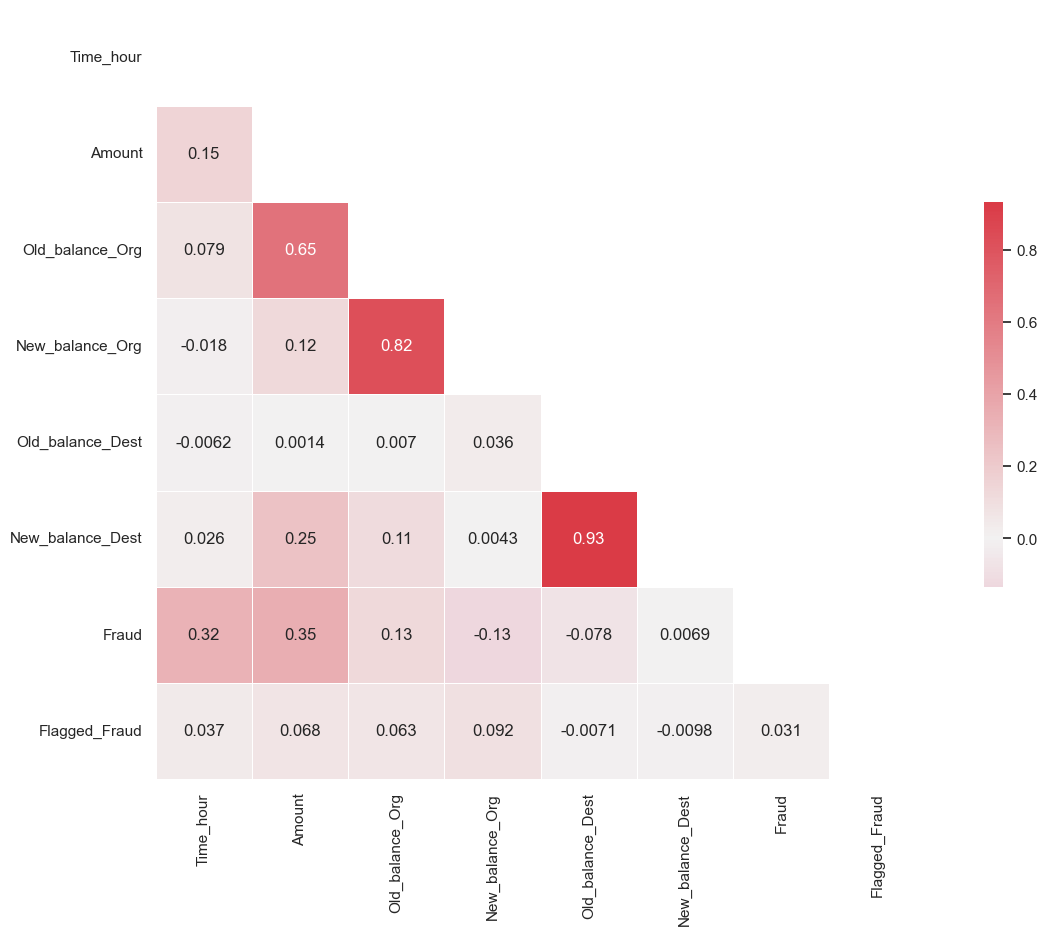

In [5]:
plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(data_downsampled.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(data_downsampled.corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

In [6]:
# Balanceado de los datos. Undersampling
data_downsampled['Fraud'].value_counts()

0    8213
1    8213
Name: Fraud, dtype: int64

In [7]:
# Codificación de la variable categórica 'Type' usando codificación One-Hot-Encoing
data_encoded = pd.get_dummies(data_downsampled, columns=["Type"], drop_first=True)
data_encoded.head()

,Time_hour,Amount,Origin_ID,Old_balance_Org,New_balance_Org,Destination_ID,Old_balance_Dest,New_balance_Dest,Fraud,Flagged_Fraud,Type_CASH_OUT,Type_DEBIT,Type_PAYMENT,Type_TRANSFER
4550565,327,13501.50,C1191059846,0.0,0.00,C73957643,740007.21,753508.71,0,0,1,0,0,0
4407469,322,105475.54,C65288331,0.0,0.00,C1201144294,4856040.02,4961515.55,0,0,1,0,0,0
5391283,377,49338.73,C1968501288,168.0,49506.73,C620264007,0.00,0.00,0,0,0,0,0,0
2604824,208,12675.67,C754156741,0.0,0.00,M1207661296,0.00,0.00,0,0,0,0,1,0
3178372,239,9272.14,C1681989971,0.0,0.00,M1318650718,0.00,0.00,0,0,0,0,1,0


## Empezamos a entrenar

In [8]:
#creo dos df porque me da error a la hora de preparar el df en mi app.
data_X = data_encoded.drop(columns=['Fraud', 'Origin_ID', 'Destination_ID', 'Flagged_Fraud'])
data_y = data_encoded['Fraud']

In [9]:
#Empezamos con todos las columnas posibles.
X = data_X
#Decidí quitar Old_balance_Org y Old_balance_Dest por la colinealidad pero me empeoró el resultado.
y = data_y

In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test

(         Time_hour      Amount  Old_balance_Org  New_balance_Org  \
 6008240        431   140461.34             0.00             0.00   
 2801119        221   684174.46        684174.46             0.00   
 3497502        259    18007.37        362952.00        380959.37   
 5987409        408    15611.83        102026.00         86414.17   
 4785013        337    46073.56         46073.56             0.00   
 ...            ...         ...              ...              ...   
 2242069        186   265813.53       9752409.20      10018222.73   
 6362587        741    62297.18         62297.18             0.00   
 6201753        578  6274752.67       6274752.67             0.00   
 10218            7    21729.00         21729.00             0.00   
 5894525        403     6761.34          1804.00             0.00   
 
          Old_balance_Dest  New_balance_Dest  Type_CASH_OUT  Type_DEBIT  \
 6008240        5579749.37        5720210.71              1           0   
 2801119            

## 1. Regresión Logística

In [11]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
print("Reporte Regresión Logística:\n", classification_report(y_test, logistic_predictions))

Reporte Regresión Logística:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      2464
           1       0.91      0.89      0.90      2464

    accuracy                           0.90      4928
   macro avg       0.90      0.90      0.90      4928
weighted avg       0.90      0.90      0.90      4928



In [12]:
with open('../data/logistic_model.pkl', 'wb') as lo:
    pickle.dump(logistic_model, lo)

## 2. Arbol de decisión

In [13]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_predictions = tree_model.predict(X_test)
print("Reporte Árbol de Decisión:\n", classification_report(y_test, tree_predictions))

Reporte Árbol de Decisión:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2464
           1       0.99      0.99      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [14]:
mse(y_test, tree_predictions, squared=False)  # rmse

0.0997155044021832

In [15]:
with open('../data/tree_model.pkl', 'wb') as dt:
    pickle.dump(tree_model, dt)

## 3. Random Forest

In [16]:
forest_model = RandomForestClassifier(random_state=42)
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
print("Reporte Bosque Aleatorio:\n", classification_report(y_test, forest_predictions))

Reporte Bosque Aleatorio:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2464
           1       0.99      1.00      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [17]:
mse(y_test, forest_predictions, squared=False)  # rmse

0.0900937462695559

In [18]:
with open('../data/forest_model.pkl', 'wb') as rf:
    pickle.dump(forest_model, rf)

este es el mejor modelo y tiene una precisión y sensibilidad del 99% de aciertos. 

## A partir de aquí vamos a visualizar los resultado de mi random forest.

In [19]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import roc_auc_score as auc

## Matriz de confusión

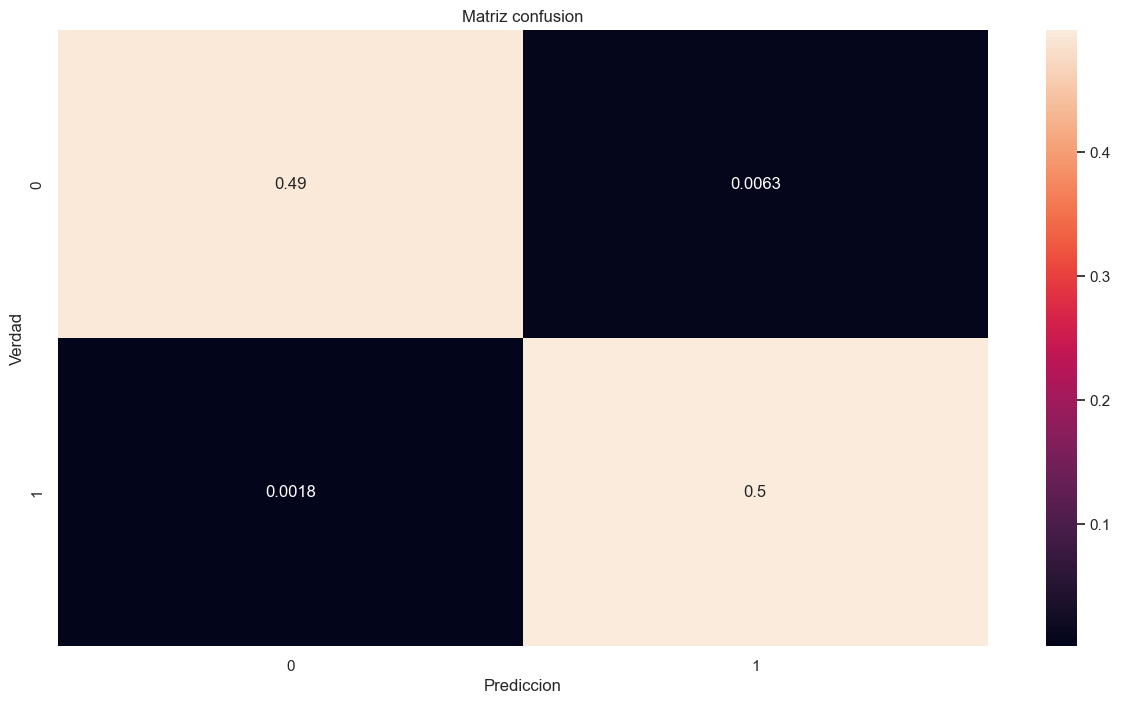

In [20]:
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test, forest_predictions)/cm(y_test, forest_predictions).sum(), annot=True)

plt.title('Matriz confusion')
plt.ylabel('Verdad')
plt.xlabel('Prediccion')
plt.show();

In [21]:
cm(y_test, forest_predictions)

array([[2433,   31],
       [   9, 2455]])

+ Verdadero no fraude: 157
+ Falso fraude: 4
+ Falso no fraude: 6. Para afinar el modelo deberíamos hacer que este resultado tienda más a un falso positivo (falso fraude) en este tipo de datos concretamente. Veremos si no aumenta al entrenar el modelo con todos los datos.
+ Verdadero fraude: 154

In [22]:
forest_prob = forest_model.predict_proba(X_test)[:,1]
forest_prob[:5]

array([0.  , 0.99, 1.  , 1.  , 0.96])

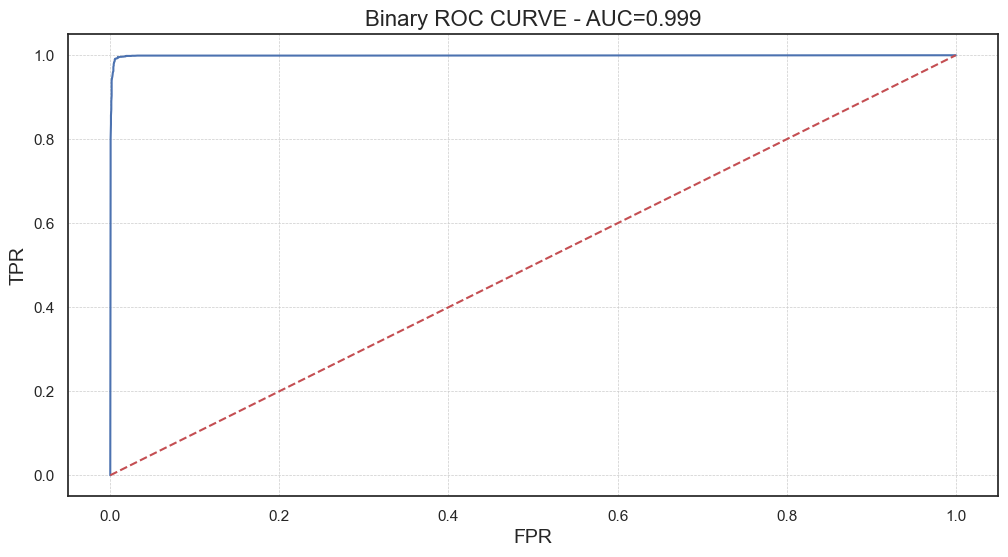

In [23]:
plt.figure(figsize=(12, 6))

fpr, tpr, _ = roc(y_test, forest_prob)   

a=auc(y_test, forest_prob)

plt.plot(fpr, tpr)

plt.plot(fpr, fpr, 'r--')

plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)

plt.title('Binary ROC CURVE - AUC={:.3f}'.format(a), fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show();